# HomeWork #2. Neural network


In [1]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt

## 1. Image reading 

*==============* Second lab *==============*
Src Image:  data/korgi.png
Shape:  (256, 256, 3)


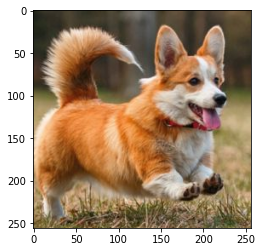

In [2]:
print("*==============* Second lab *==============*")
path_to_img = "data/korgi.png"
print("Src Image: ", path_to_img)
img = cv2.imread(path_to_img)
print("Shape: ", img.shape)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## 2. Convolution


In [3]:
def conv(src, weights):
    ic, ih, iw = src.shape
    oc, kc, kh, kw = weights.shape
    
    if (ic != kc):
        print("[ ERROR ] Input channel count of data are not equal weight channel count!")
        return

    dst = np.zeros(shape=(oc, ih, iw))

    for m in range(oc):
        for y in range(ih):
            for x in range(iw):
                for j in range(-kh // 2, kh // 2):
                    for i in range(-kw // 2, kw // 2):
                        for k in range(ic):
                            dst[m, y, x] += src[k, max(y + j, 0), min(x + j, iw - 1)] * weights[m, k, j, i]
    return dst 

## 3. Normalize

In [4]:
# for convenience, let the epsilon be outside the sqrt
# and let we calculate normalize for last two axis
def normalize(src, gamma, beta):
    dst = np.zeros(shape=src.shape)
    c, h, w = src.shape
    eps = 1e-6
    
    mu = np.average(src, axis=(1, 2))
    stddev = np.std(src, axis=(1, 2))
    for m in range(c):
        dst[m,:,:] = (src[m,:,:] - mu[m]) / (stddev[m] + eps)
        dst[m,:,:] = gamma[m,:,:] * dst[m,:,:] + beta[m,:,:]
    return dst

## 4. ReLU

In [5]:
def relu(src):
    return np.maximum(src, 0)

## 5. MaxPooling

In [6]:
def maxpool(src):
    c, ih, iw = src.shape
    kh = 2
    kw = 2
    sh = kh  # stride by h
    sw = kw  # stride by w
    
    oh = int(np.ceil((ih - kh) / sh) + 1)
    ow = int(np.ceil((iw - kw) / sw) + 1)
    
    dst = np.zeros(shape=(c, oh, ow))
    
    for m in range(c):
        for y in range(oh):
            for x in range(ow):
                y_start = min(y * sh, ih - 1)
                y_finish = min(y * sh + kh, ih - 1)
                x_start = min(x * sw, iw - 1)
                x_finish = min(x * sw + kw, iw - 1)
                dst[m, y, x] = np.amax(src[m, y_start : y_finish, x_start : x_finish], axis=(0, 1))
    return dst

## 6. SoftMax

In [7]:
# do softmax for spatial dimensions (not channel)
def softmax(src):
    c, h, w = src.shape
    tmp = np.reshape(src, (c, h * w))
    h = h * w
    max_value = np.reshape(np.amax(tmp, axis = 1), (c, 1))
    exp = np.exp(tmp - max_value) # to avoid exp overflow
    sum = np.sum(exp, axis=1)
    dst = np.zeros(shape=(c, h))
    
    for m in range(c):
        dst[m,:] = exp[m,:] / sum[m]
    return dst

## Network
input -> conv -> normalize -> ReLU -> MaxPooling -> SoftMax

In [8]:
input_blob = np.transpose(img, (2, 1, 0))

# conv
weights = np.random.rand(5, 3, 3, 3)
blob_after_conv = conv(input_blob, weights)

In [9]:
# normalize
input_shape = blob_after_conv.shape
gamma = np.random.uniform(2, 8, input_shape)
beta = np.random.uniform(2, 8, input_shape)
blob_after_normalize = normalize(blob_after_conv, gamma, beta)

In [10]:
# relu
blob_after_relu = relu(blob_after_normalize)

In [11]:
# maxpooling
print("Shape before MaxPooling 2x2: ", blob_after_relu.shape)
blob_after_maxpool = maxpool(blob_after_relu)
print("Shape after MaxPooling 2x2: ", blob_after_maxpool.shape)

Shape before MaxPooling 2x2:  (5, 256, 256)
Shape after MaxPooling 2x2:  (5, 128, 128)


In [12]:
# softmax
output = softmax(blob_after_maxpool)
print("Output shape: ", output.shape)

Output shape:  (5, 16384)


In [13]:
predictions = -np.sort(-output, axis=-1)
c, h = predictions.shape
for m in range(c):
    print("Channel #{0}: {1}".format(m, predictions[m][0:5]))

Channel #0: [0.20924107 0.11812632 0.04112854 0.03674496 0.03256177]
Channel #1: [0.17548929 0.07307391 0.06715041 0.04541765 0.03999998]
Channel #2: [0.13799518 0.07835213 0.069839   0.06704913 0.05278623]
Channel #3: [0.38417774 0.19344426 0.07392288 0.03086999 0.02828755]
Channel #4: [0.12993399 0.09899018 0.08678102 0.08423084 0.0621169 ]
